In [3]:
%run ./ipy_setup.py

In [165]:
def describe(obj):
    return obj, type(obj), len(obj)
pd.set_option('display.width', 900)
pd.set_option('display.max_columns', 100)
plt.style.use('ggplot')
rcParams['figure.figsize'] = (12, 8)
rcParams['figure.dpi'] = 150
rcParams['font.size'] = 16
rcParams['font.family'] = 'Bitstream Vera Sans'

# Barcode parser

In [6]:
!samtools index /hpc/users/neffr01/jason_new/tenx/NIST_NA24385_possorted_bamout.fixed.sorted.000000F.bam

In [8]:
tenx_bam = pysam.AlignmentFile("/hpc/users/neffr01/jason_new/tenx/NIST_NA24385_possorted_bamout.fixed.sorted.000000F.bam", 'rb')

In [15]:
for read in tenx_bam.fetch():
    barcode = read.qname.split("_")[1].split('-')[0]
    print describe(barcode)
    break

('TGCGTACACATCCA', <type 'str'>, 14)


In [17]:
excelfile = '/hpc/users/neffr01/jason_new/hapcut_outputs/hg002_re_000000F/hapcut_qv13_mq10/hg002.000000F.qv13mq10.redo.merged.iblockstats.tsv'
interblock_stats = pd.read_csv(excelfile, sep='\t')

In [ ]:
for block in barcodes:
    for code in barcodes[block]:
        print code

In [125]:
barcodes = dict()
spans = zip(interblock_stats['block1_end'], interblock_stats['block2_start'])
pbar = ProgressBar(len(spans))
count = 1
for start, end in spans:
    #print start, end, end-start
    pbar.animate()
    barcodes[count] = dict()
    for read in tenx_bam.fetch(region="000000F", start=max(start-10000, 0), end=end+10000):
        barcode = read.qname.split("_")[1].split('-')[0]
        if barcode in barcodes[count]:
            barcodes[count][barcode]['pos'].append(int(read.pos))
            barcodes[count][barcode]['count'] += 1
        else:
            readdict = dict()
            readdict['pos'] = [int(read.pos)]
            readdict['count'] = 1            
            barcodes[count][barcode] = readdict
    count += 1

[*****************83%************      ]  242 of 292 complete Elapsed: 0.2 minutes	 Remaining: 0.0 minutes


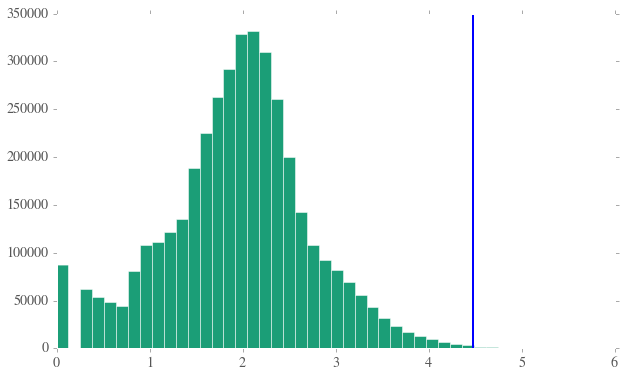

99.890612138


In [126]:
hist = []
cutoff=30000
for block in barcodes:
    for barcode in barcodes[block]:
        hist.extend(list(np.diff(barcodes[block][barcode]['pos'])))
plt.hist(np.log10(hist), bins=np.linspace(0,5,40))
plt.axvline(np.log10(cutoff), 0, 400)
plt.show()
print (1-len([i for i in hist if i >= cutoff])/float(len(hist)))*100

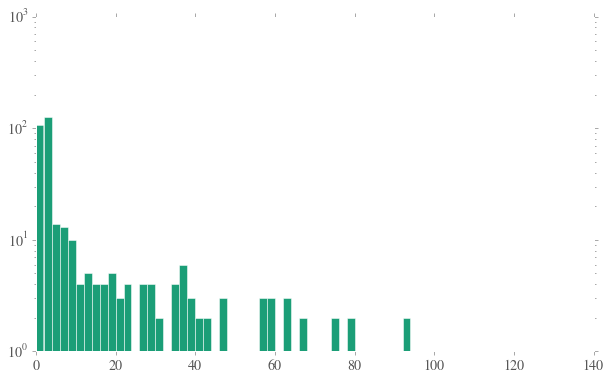

In [65]:
plt.hist([val['count'] for ix, val in barcodes[7].iteritems()], bins=range(0,140,2), log=True)
plt.show()

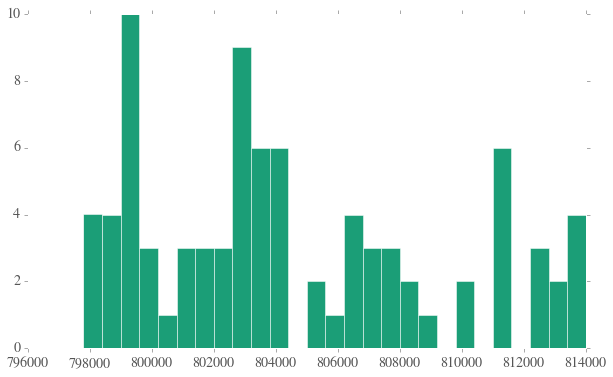

In [71]:
positions = barcodes[7]['AACGCTAGTATCGA']['pos']
plt.hist(positions, bins=range(min(positions), max(positions), 600))
plt.show()

In [128]:
for block in barcodes:
    for barcode in barcodes[block]:
        if barcodes[block][barcode] <= 10:
            continue # too few barcodes
        positions = barcodes[block][barcode]['pos']
        ranges = []
        startrange = positions[0]
        lastrange = positions[0]
        for ix,i in enumerate(positions[1:]):
            if startrange == None:
                startrange = i
                lastrange=i
                continue
            if i - lastrange > 30000:
                ranges.append((startrange, lastrange))
                startrange = None
            lastrange = i
        ranges.append((startrange, lastrange))
        barcodes[block][barcode]['ranges'] = ranges

In [167]:
count = 1
support_array = []
for start, end in spans:
    array = []
    support = 0
    for ix, val in barcodes[count].iteritems():
        array.append([val['count'], ix, val['ranges']])
    for cnt, barcode, ranges in array:
        if len([item for sublist in ranges for item in sublist]) > 2:
            for i in range(0,len(ranges)):
                if (ranges[i][0] <= start) & (ranges[i][1] >= end):
                    support += 1
        if len(ranges) > 0:
            if (ranges[0][0] <= start) & (ranges[0][1] >= end):
                support += 1
    support_array.append([count, start, end, end-start, support])
    count += 1

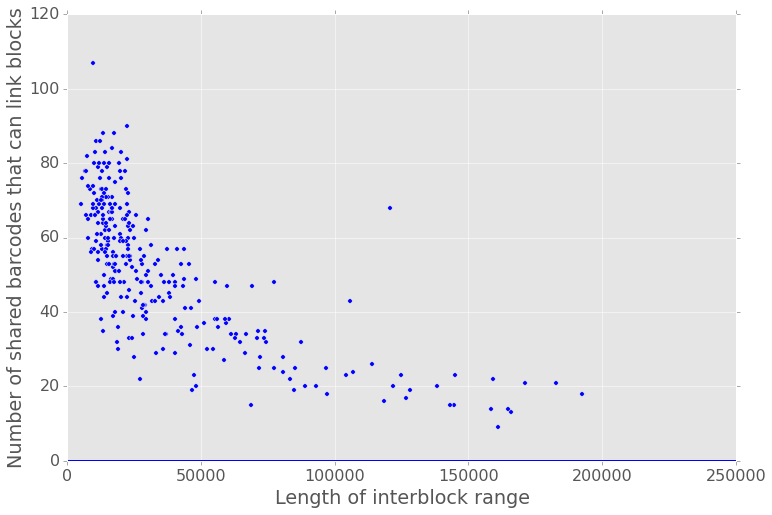

In [171]:
plt.scatter([i[3] for i in support_array], [i[4] for i in support_array])
plt.axhline(0,250000,0)
plt.xlim([0,250000])
plt.ylabel("Number of shared barcodes that can link blocks")
plt.xlabel('Length of interblock range')
plt.show()

In [330]:
def hamming_dist(str1, str2):
    difference = 0
    supp = 0
    for x,y in zip(str1, str2):
        if x != y:
            difference += 1
        if x == y:
            supp += 1
    return difference, supp

def get_refmap(bamread):
    bpos = bamread.get_aligned_pairs(matches_only=True)
    positions = [i[0] for i in bpos]
    refpos =  [i[1] for i in bpos] # positions in reference
    refmap = dict(zip(refpos, positions))
    return refmap

def get_matched_bases_in_read(bamread, in_pos, refmap):
    outseq = [bamread.seq[refmap[i]] if i in refmap else 'N' for i in in_pos]
    outseq = ''.join(outseq)
    outqual = [bamread.qual[refmap[i]] if i in refmap else 'N' for i in in_pos]
    outqual = ''.join(outqual)
    return outseq, outqual

def get_bases_between_two_ref_positions(bamread, pos1, pos2, refmap):
    outseq, outqual = '', ''
    refpos1, refpos2 = None, None
    positions = []
    for i in range(pos1,pos2+1):
        if (i not in refmap) and (refpos1 == None):
            outseq += 'N'
            outqual += '!'
            continue
        elif refpos1 == None:
            refpos1 = refmap[i]
        if i in refmap:
            refpos2 = refmap[i]
    try:
        outseq += ''.join([bamread.seq[i] for i in range(refpos1,refpos2)])
        outqual += ''.join([bamread.qual[i] for i in range(refpos1,refpos2)])
    except:
        pass
    return outseq, outqual

def reverse_compl(seq):
    translate = {'A':'T', 
                 'T':'A', 
                 'C':'G',
                 'G':'C'}
    return ''.join([translate[s] for s in seq])

In [205]:
a = [1,2,2,3,3,3,4,4,4]
atruth = [1 if i==2 else 0 for i in a]

[0, 1, 1, 0, 0, 0, 0, 0, 0]

In [ ]:
# Okay, now let's link SNPs together on a  networkx multi-di-graph
import networkx as nx
from collections import defaultdict
from scipy.stats import mode

tenx_bam = pysam.AlignmentFile("/hpc/users/neffr01/jason_new/tenx/NIST_NA24385_possorted_bamout.fixed.sorted.000000F.bam", 'rb')
vcffile = ht.VCF_Reader("/hpc/users/neffr01/jason_new/hapcut_outputs/hg002_re_000000F/hg002_short_reads_rg-rmdup_000000F.freebayes.vcf")
vcffile.parse_meta()
vcffile.make_info_dict()
snpDict = dict()
barcodegraph = nx.Graph()
lastreads = dict()
count = 0
pbar = ProgressBar(115000)
for var in vcffile:
    pbar.animate()
    vargeno = var.samples['hg002']['GT']
    if vargeno == '1/1' or vargeno == '0/0':
        continue
    varlen = len(var.ref)
    if varlen > 1:
        continue # TODO - this is complicated
    count += 1
    #print var, var.pos.pos, var.ref, var.alt, varlen, var.samples['unknown']['GT']
    if var.chrom != "000000F":
        break # we're done
    # lets add the node to the graph
    barcodegraph.add_node(var.chrom + ":" + str(var.pos.pos) + "_0", attr_dict={'description':str(var)})
    for i in range(0, len(var.alt)):
        i += 1
        barcodegraph.add_node(var.chrom + ":" + str(var.pos.pos) + "_" + str(i), attr_dict={'description':str(var)})
    barcodeset = defaultdict(list)
    for read in tenx_bam.fetch(region="000000F", start=var.pos.pos, end=var.pos.pos+len(var.ref)):
        barcode = read.qname.split("_")[1].split('-')[0]
        refmap = get_refmap(read)
        outseq, outqual = get_matched_bases_in_read(read, range(var.pos.pos-1, var.pos.pos+varlen-1), refmap)
        if (outseq == ''):
            continue
        if (outseq[0] == 'N'):
            continue
        r, r_supp = hamming_dist(outseq, var.ref)
        a_diff = [hamming_dist(outseq, i)[0] for i in var.alt]
        a_supp = [hamming_dist(outseq, i)[1] for i in var.alt]
        genotype=None
        if r<min(a_diff):
            genotype=0
        elif min(a_diff)<r:
            atruth = [1 if i==min(a_diff) else 0 for i in a_diff]
            if sum(atruth) > 1:
                #print "WARNING: More than one match for alternate allele, skipping..."
                #print "read:", outseq, barcode, read.is_reverse, read.pos
                continue
            genotype=atruth.index(1)+1
        if genotype > 1:
            continue
        #else:
        #    if r_supp > max(a_supp):
        #        genotype=0
        #    elif max(a_supp) > r_supp:
        #        atruth = [1 if i==max(a_supp) else 0 for i in a_supp]
        #        if sum(atruth) > 1:
        #            #print "WARNING: More than one match for alternate allele, skipping..."
        #            #print "read:", outseq, barcode, read.is_reverse, read.pos
        #            continue
        #        genotype=atruth.index(1)+1
        #    else:
        #        #print "WARNING: No strong match to ref or alt sequence, skipping..."
        #        #print "read:", outseq, barcode, read.is_reverse, read.pos
        #        continue
        #print outseq, outqual, genotype, barcode, read.is_reverse, read.pos
        # now lets add the read edges
        barcodeset[barcode].append(genotype)
        snpDict[str(var)] = barcodeset
    for i,val in barcodeset.iteritems():
        most_likely_geno = int(mode(val)[0][0])
        geno_support = int(mode(val)[1][0])
        nodename = var.chrom + ":" + str(var.pos.pos) + "_" + str(most_likely_geno)
        if i in lastreads:
            num_edges = geno_support + lastreads[i][1]
            a = lastreads[i][0]
            b  = nodename
            if int(b.split(":")[1].split("_")[0]) < int(a.split(":")[1].split("_")[0]) + 1000000:
                if (a,b) in barcodegraph.edges():
                    weight = barcodegraph.edge[a][b]['weight'] + num_edges
                    barcodegraph.add_edge(a,b,weight=weight)
                else:
                    barcodegraph.add_edge(a,b,weight=num_edges)
        lastreads[i] = (nodename, geno_support)
    #break
    #print barcodeset
    #if count > 1000:
    #    break

In [334]:
nx.write_gexf(barcodegraph, "/hpc/users/neffr01/barcodegraph_tenx_snps_indels_000000F_30k.gexf")

In [339]:
barcodegraph.edge['000000F:4415338_1']

{'000000F:4411090_1': {'weight': 2},
 '000000F:4413303_1': {'weight': 3},
 '000000F:4415276_0': {'weight': 2},
 '000000F:4415354_1': {'weight': 10}}

# Interblock definitions

In [2]:
excelfile = '/hpc/users/neffr01/jason_new/hapcut_outputs/hg002_re_000000F/hapcut_with_indels/hg002_000000F.indels.interblock_stats.tsv'
interblock_stats = pd.read_csv(excelfile, sep='\t')

In [3]:
def n50(arr):
    calcarr = [list(np.ones(x).astype(int)*x) for x in arr]
    calcarr = [item for sublist in calcarr for item in sublist]
    return np.median(calcarr)